# 02 State and feedback instrumentation

Let’s make the training state explicit and inspect it like a first‑class object.

We won’t train here — just snapshot the state after one pseudo‑label pass.



### Note on the first pass

At this point the model is untrained, so predictions are close to uniform.

It’s normal to see `accept_rate = 0.0` with a high threshold (e.g., 0.8).

This is why SSL pipelines typically warm‑up on labeled data or ramp up the unlabeled loss.



## Step 1: Imports and setup

Load MNIST, the model, and metric helpers.



In [10]:
from pathlib import Path
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(str(Path.cwd().parent / 'src'))

from utils.seed import set_seed
from utils.metrics import entropy_from_probs
from data.mnist import get_mnist_ssl
from models.small_cnn import SmallCNN


## Step 2: Initialize a cold model

We start with an untrained model to show how low‑confidence the state can be.



In [11]:
set_seed(0)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loaders = get_mnist_ssl(
    data_dir='data',
    labeled_per_class=50,
    batch_size=128,
    num_workers=2,
    seed=0,
)

model = SmallCNN().to(DEVICE)
model.eval()


SmallCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Step 3: Build a state snapshot

Run one forward pass to get pseudo‑labels, confidence, and the selection mask.



In [12]:
# Single unlabeled batch -> state snapshot
u_images, u_labels = next(iter(loaders.unlabeled_eval))
u_images = u_images.to(DEVICE)
with torch.no_grad():
    logits = model(u_images)
    probs = torch.softmax(logits, dim=1)
    conf, pseudo = torch.max(probs, dim=1)

threshold = 0.8
mask = conf >= threshold

state = {
    'pseudo_probs': probs.cpu(),
    'pseudo_labels': pseudo.cpu(),
    'mask_selected': mask.cpu(),
    'confidence': conf.cpu(),
}

summary = {
    'accept_rate': float(mask.float().mean().item()),
    'avg_conf_selected': float(conf[mask].mean().item()) if mask.any() else 0.0,
    'entropy': entropy_from_probs(probs).item() if hasattr(entropy_from_probs(probs), 'item') else entropy_from_probs(probs),
}
summary


{'accept_rate': 0.0, 'avg_conf_selected': 0.0, 'entropy': 2.301820993423462}

## Step 4: Visualize confidence

The histogram shows how much data actually passes the threshold.



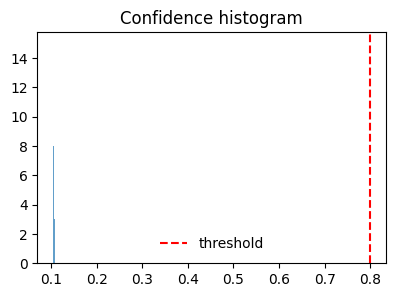

In [13]:
plt.figure(figsize=(4.5, 3))
plt.hist(state['confidence'].numpy(), bins=20, alpha=0.7)
plt.axvline(threshold, color='r', linestyle='--', label='threshold')
plt.title('Confidence histogram')
plt.legend(frameon=False)


### Expected Outcome

A cold model should produce low confidence and high entropy, so the accept rate at a high threshold is low.


## Observations → Why → SSL opportunity

**What you’ll likely see**

- Most predictions start low‑confidence (especially early).

- Only a small slice clears a high threshold.



**Why this matters**

- The state (pseudo‑labels, confidence, selection mask) drives recursion.

- If the state is noisy, the loop amplifies errors.



**SSL opportunity**

- Stabilizers (thresholds, soft labels, EMA teachers) act on the state.

